# Intel & MobileODT Cervical Cancer Screening
A Custom CNN using Keras over Tensorflow has been created. The data has been extracted into a numpy file. 

In [1]:
pip install piexif

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import piexif
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import sys

In [3]:
#Images are going to be square so set size to 32 to be used for both width and height.
img_size = 32
train_dir = r"C:\Users\Dwayne D'costa\Documents\Anglia Ruskin University\Tutorials\Neural Computing and Deep Learning\Cervical_Cancer_Kaggle-master\intel-mobileodt-cervical-cancer-screening\train\train"
test_dir = r"C:\Users\Dwayne D'costa\Documents\Anglia Ruskin University\Tutorials\Neural Computing and Deep Learning\Cervical_Cancer_Kaggle-master\intel-mobileodt-cervical-cancer-screening\test\test"

In [4]:
def PreProcess_Images(root, train=True):
    features = []
    labels = []
    
    for subdir, dirs, files in os.walk(root):
        count  = 0
        for file in files:
            tot_files = len(files)
            if not file == ".DS_Store":
                count += 1
                sys.stdout.write("\rFile = " + file + " ----- Progress: {:2.1f}%".format(100 * count/float(tot_files)))
                img = os.path.join(subdir, file)
                #Remove exif data - This is because there is a lot of corrupt exif data in this dataset.
                if os.stat(img).st_size > 0:
                    piexif.remove(img)
                else:
                    continue
                #Open image and resize to designated width and height. 
                im = cv2.imread(img)
                im = cv2.resize(im, (img_size, img_size))
                #Extract features into a numpy array.
                feature = np.array(im, dtype=np.float32)
                #append feature to features list.
                features.append(feature)
                
                #only apply labels for training data. 
                if train == True:
                    #Get label from directory name.
                    label = os.path.basename(subdir)
                    #One hot encoding of label names.
                    if label == "1":
                        label = [1,0,0]
                    elif label == "2":
                        label = [0,1,0]
                    else:
                        label = [0,0,1]
                    #append label to labels list.    
                    labels.append(label)
                #add image filename to labels to be used in formatting of submission data.
                else:
                    label = os.path.basename(img)
                    labels.append(label)
                sys.stdout.flush()
    
    if train == True:
        labels = np.array(labels, np.uint8)
        
    features = np.array(features, np.float32) / 255.
    
    return features, labels

In [5]:
# Obtain Training X and y lists.
X, y = PreProcess_Images(train_dir, train=True)

File = 996.jpg ----- Progress: 100.0%

In [6]:
# Obtain test X and filenames of test images
X_test, flnm_test = PreProcess_Images(test_dir, train=False)

File = 99.jpg ----- Progress: 100.0%

In [7]:
#Split training data into training and validation data.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
#Save all information to a numpy archive file to be used when training the model.
np.savez('data_arrays', X_train, y_train, X_valid, y_valid, X_test, flnm_test)

In [9]:
import numpy as np
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import Callback
from keras import regularizers
from keras import optimizers

In [10]:
def SummaryGraphs(hist):
    # summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [11]:
def QuickModel(learning_rate, opt_momentum, opt_decay, dropout):
    #Quick Keras Model
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    model.add(Dropout(dropout))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=learning_rate, momentum=opt_momentum, decay=opt_decay),
                  metrics=['accuracy']
                 )
    return model

In [12]:
def Train(learning_rate, momentum, decay, dropout, epochs, batch_size, slice_size, xtrain, ytrain, xval, yval, logging=0, graph=False):
    #Model
    model = QuickModel(learning_rate, momentum, decay, dropout)

    #Fit Model and save results to history for graphing later.
    history = model.fit(xtrain[:slice_size], ytrain[:slice_size],
              batch_size=batch_size,
              epochs=epochs,
              verbose=logging,
              validation_data=(xval[:slice_size], yval[:slice_size]))
    if graph == True:
        SummaryGraphs(history)
    return model

In [13]:
#Extract Data for training and testing from the .npz file.
with np.load('data_arrays.npz') as data:
    xtr = data['arr_0']
    ytr = data['arr_1']
    xvl = data['arr_2']
    yvl = data['arr_3']
    xts = data['arr_4']
    yts = data['arr_5']

# Sanity Checks
Reference: [CS231](http://cs231n.github.io/neural-networks-3/#sanitycheck)

### 1) Look for correct loss at chance performance.
   * Diffuse Probability = 0.33 for each class (3 classes).
   * Softmax => -ln(correct class) = -ln(0.33) = 1.10866 => Estimated Loss at start of training.
   * Set Regularization(dropout) to zero.
   * Initialize hyperparameters as small values.

In [14]:
from tensorflow.keras import optimizers

Train(learning_rate=0.0, momentum=0.0, decay=0.0, dropout=0.0, epochs=1, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=1)

C:\Users\Dwayne D'costa\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 116ms/step - loss: 1.1202 - accuracy: 0.0633 - val_loss: 1.1195 - val_accuracy: 0.0539


   * As we can see the inital model training loss is pretty close to what we expect.

### 2) As a second sanity check, increasing the regularization strength should increase the loss.

   * The dropouut rate will be increased which means we should see the loss increase from above.

In [15]:
Train(learning_rate=0.0, momentum=0.0, decay=0.0, dropout=0.5, epochs=1, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=1)

10/10 [==============================] - 2s 158ms/step - loss: 1.2390 - accuracy: 0.1478 - val_loss: 1.1313 - val_accuracy: 0.0034


   * We can see that the training loss increased from 1.1186 to 1.1313 with a dropout of 0.5

### 3) Overfit a tiny subset of data.
   * If I can't reach a loss of zero, then there is a problem.
   * Set the regularization(dropout) to zero.

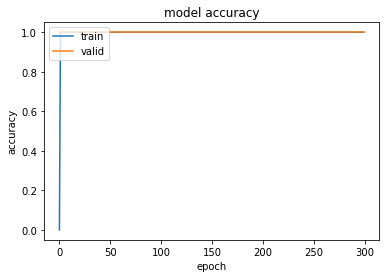

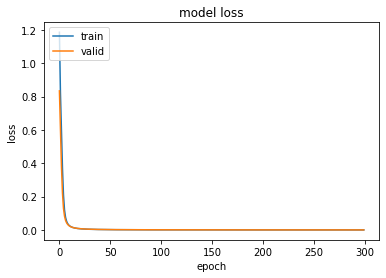

In [16]:
Train(learning_rate=0.01, momentum=0.0, decay=0.0, dropout=0.0, epochs=300, 
      batch_size=128, slice_size=10, xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

* As we can see in the "model loss" graph, the training loss has gone to zero. Thus, I was able to overfit the model with a small subset of the data.

# Training
* I will now begin to experiment with hyperparameters during training to determine the best solution for this particular model. 

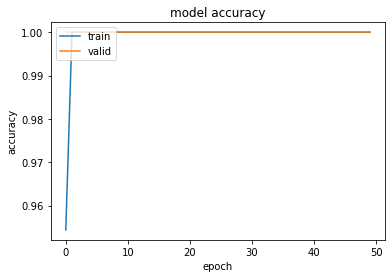

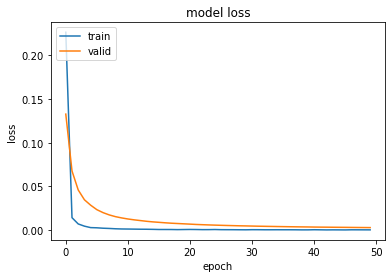

In [17]:
model = Train(learning_rate=0.01, momentum=0.0, decay=0.0, dropout=0.5, epochs=50, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

It looks like we still have some to gain from this model. I'm going to leave everything the same except for learning rate and see how it performs. I will increase the learning rate.

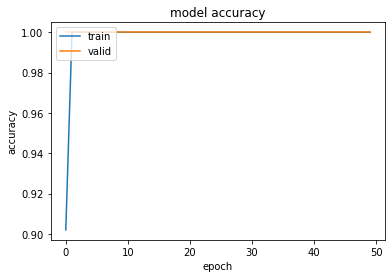

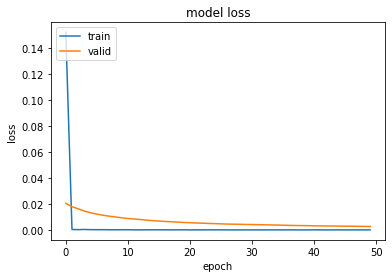

In [18]:
model = Train(learning_rate=0.05, momentum=0.0, decay=0.0, dropout=0.5, epochs=50, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

The validation and training accuracy started to drift apart just after 30 epochs. So I'm going to decrease the learning rate back down to 0.01 increase the epochs and give it a little bit of momentum.

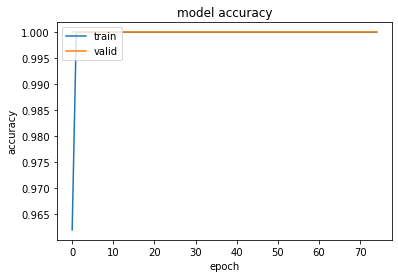

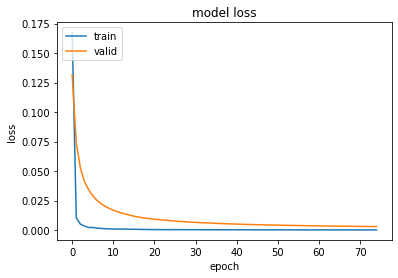

In [19]:
model = Train(learning_rate=0.01, momentum=0.01, decay=0.0, dropout=0.5, epochs=75, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

........

After playing around with hyperparameters I have settled on this model for now.

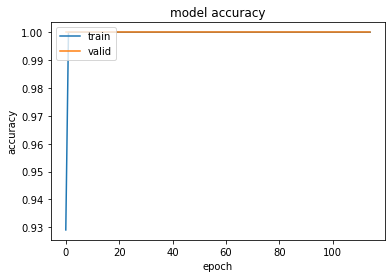

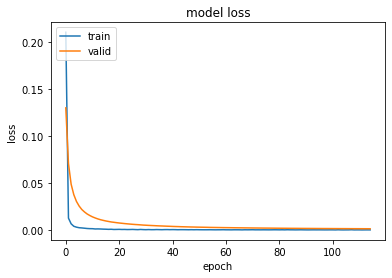

In [20]:
model = Train(learning_rate=0.01, momentum=0.01, decay=0.0, dropout=0.5, epochs=115, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

Below I will create a submission and submit it to Kaggle for official scoring.

In [22]:
def Submission(mod, img_names, test_imgs):
    #Create Prediction File(.csv)
    test_predictions = mod.predict(test_imgs, batch_size=32, verbose=0)
    test_data = np.column_stack((img_names,test_predictions))
    dfPreds = pd.DataFrame(data=test_data,columns=['image_name','Type_1','Type_2','Type_3'])
    dfPreds.to_csv('submission_1.csv', index=False)

In [23]:
Submission(model, yts, xts)

This model had a logloss of 0.91613 on the test data in the Kaggle submission.